In [1]:
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False
rc('font', family='AppleGothic')

pd.set_option('display.max_columns', None)

In [2]:
import pickle

with open('datas/total_modeling_dataset.pkl', 'rb') as f:
    players_df = pickle.load(f)

In [3]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 42 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   market_value    867 non-null    int64  
 1   app             867 non-null    int64  
 2   conceded_goals  867 non-null    float64
 3   clean_sheets    867 non-null    float64
 4   yellow_card     867 non-null    float64
 5   second_yell     867 non-null    object 
 6   red_card        867 non-null    object 
 7   age             867 non-null    int64  
 8   height          867 non-null    int64  
 9   position        867 non-null    object 
 10  foot            867 non-null    object 
 11  club            867 non-null    object 
 12  outfitter       867 non-null    object 
 13  sns             867 non-null    int64  
 14  cup             867 non-null    int64  
 15  Tackles         867 non-null    float64
 16  Inter           867 non-null    float64
 17  Fouls           867 non-null    flo

In [5]:
players_df.drop('mm_value', axis=1, inplace=True)
players_df.shape

(867, 41)

In [6]:
players_df.tail()

,market_value,app,conceded_goals,clean_sheets,yellow_card,second_yell,red_card,age,height,position,foot,club,outfitter,sns,cup,Tackles,Inter,Fouls,Offsides,Clear,Drbed,Blocks,OwnG,Assists,KeyP,AvgP,PS,Crosses,LongB,ThrB,Rating,Goals,SpG,Drb,Fouled,Off,Disp,UnsTch,AerialsWon,MotM,period
862,1080000,22,0.0,0.0,0.2,0,0,26,186,attack,right,Cádiz CF,adidas,1,0,0.6,0.1,1.3,0.0,0.3,0.9,0.0,0.0,6.32,1.0,1.0,0.6,0.5,1.0,0.2,0.6,0.1,7.2,67.3,0.6,0.2,0.0,0.6,1.0,0.6,5.5
863,900000,27,0.0,0.1,0.1,0,0,28,182,attack,right,Cádiz CF,adidas,1,0,0.4,0.1,0.6,0.0,0.0,0.4,0.0,0.0,6.10,0.0,1.0,0.3,0.1,0.5,0.3,0.4,0.0,5.4,59.2,0.1,0.2,0.0,0.4,0.0,0.3,3.5
864,1350000,20,0.0,0.0,0.1,0,0,28,185,attack,right,Cádiz CF,Nike,2,1,1.6,0.9,1.1,0.0,0.7,0.5,0.0,0.0,6.71,1.0,0.0,0.6,0.7,1.7,0.3,0.6,0.1,14.9,74.6,0.1,0.2,0.0,2.1,1.0,0.0,1.5
865,1080000,9,0.1,0.0,0.2,0,0,23,190,attack,right,Cádiz CF,Nike,1,3,0.1,0.1,1.6,0.0,0.4,0.2,0.0,0.0,6.48,1.0,0.0,1.2,0.0,1.8,0.4,0.8,0.1,9.0,72.8,0.0,0.0,0.0,3.4,0.0,0.6,1.5
866,1080000,34,0.2,0.1,0.1,1,0,35,186,attack,left,Cádiz CF,New Balance,2,6,0.3,0.1,0.6,0.1,0.6,0.2,0.1,0.0,6.73,7.0,4.0,1.4,0.6,1.1,0.2,0.6,0.0,16.0,57.1,0.0,0.6,0.1,3.7,4.0,0.9,1.1


In [7]:
cate_var = []
cons_var = []
for col in players_df.columns:
    if players_df[col].dtype == "O":
        cate_var.append(col)
    else:
        cons_var.append(col)
        
print("범주형 :", cate_var)
print()
print("수치형 :", cons_var)

범주형 : ['second_yell', 'red_card', 'position', 'foot', 'club', 'outfitter']

수치형 : ['market_value', 'app', 'conceded_goals', 'clean_sheets', 'yellow_card', 'age', 'height', 'sns', 'cup', 'Tackles', 'Inter', 'Fouls', 'Offsides', 'Clear', 'Drbed', 'Blocks', 'OwnG', 'Assists', 'KeyP', 'AvgP', 'PS', 'Crosses', 'LongB', 'ThrB', 'Rating', 'Goals', 'SpG', 'Drb', 'Fouled', 'Off', 'Disp', 'UnsTch', 'AerialsWon', 'MotM', 'period']


In [8]:
cons_var = cons_var[1:]
print(cons_var[:7])

['app', 'conceded_goals', 'clean_sheets', 'yellow_card', 'age', 'height', 'sns']


In [9]:
from patsy import dmatrix
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold


# OLS 모델을 만든 후 5번의 교차검증을 통해 r2-score, mse, rmse의 평균값을 출력해주는 함수
def get_scores(df, formula, inplace=False, get_model=False, show_dfX=False):
    
    scores = np.zeros(5)
    mses = np.zeros(5)
    rmses = np.zeros(5)
    cv = KFold(5, shuffle=True, random_state=3)
    for i, (idx_train, idx_test) in enumerate(cv.split(df)):
        
        df_X = dmatrix(formula, df, return_type='dataframe')
        df_y = df['market_value']
        
        X_train, X_test = df_X.iloc[idx_train], df_X.iloc[idx_test]
        y_train, y_test = df_y.iloc[idx_train], df_y.iloc[idx_test]

        model = sm.OLS(y_train, X_train).fit()
        pred = model.predict(X_test)
        
        mse = metrics.mean_squared_error(y_test, pred)
        rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
        r_squared = r2_score(y_test, pred)
        
        scores[i] = r_squared
        mses[i] = mse
        rmses[i] = rmse
    
    avg_r_score = np.mean(scores).round(4)
    avg_mse = np.mean(mses).round(4)
    avg_rmse = np.mean(rmses).round(4)
    
    print("r-score :", avg_r_score)
    print("mse :", avg_mse)
    print("rmse :", avg_rmse)
    
    if inplace:
        return [avg_r_score, avg_mse, avg_rmse]
    
    if get_model:
        return model, [avg_r_score, avg_mse, avg_rmse]
    
    if show_dfX:
        return df_X, [avg_r_score, avg_mse, avg_rmse]
    
    
# 두 모델의 성능을 비교해주는 함수
def compare_scores(prev_score, curr_score):
    print("r-score 변화량: ", (curr_score[0] - prev_score[0]).round(4))
    print("mse 변화량 :", (curr_score[1] - prev_score[1]).round(4))
    print("rmse 변화량 :", (curr_score[2] - prev_score[2]).round(4))

## Model_1
- 데이터 전처리만 완료한 dataset에서 수치형 변수로만 모델링
    - 수치형
        - Original
    - 종속변수
        - Original

In [10]:
model_df = players_df.copy()
formula = "+".join(cons_var)
print(formula)

app+conceded_goals+clean_sheets+yellow_card+age+height+sns+cup+Tackles+Inter+Fouls+Offsides+Clear+Drbed+Blocks+OwnG+Assists+KeyP+AvgP+PS+Crosses+LongB+ThrB+Rating+Goals+SpG+Drb+Fouled+Off+Disp+UnsTch+AerialsWon+MotM+period


In [11]:
score_1 = get_scores(model_df, formula, inplace=True)

r-score : 0.5753
mse : 114239234843577.16
rmse : 10653901.6933


## Model_2
- 모든 변수로 모델링
    - 범주형
        - Original
    - 수치형
        - Original
    - 종속변수
        - Original

In [12]:
model_df = players_df.copy()
formula = "+".join(cons_var + ["C({})".format(col) for col in cate_var])
print(formula)

app+conceded_goals+clean_sheets+yellow_card+age+height+sns+cup+Tackles+Inter+Fouls+Offsides+Clear+Drbed+Blocks+OwnG+Assists+KeyP+AvgP+PS+Crosses+LongB+ThrB+Rating+Goals+SpG+Drb+Fouled+Off+Disp+UnsTch+AerialsWon+MotM+period+C(second_yell)+C(red_card)+C(position)+C(foot)+C(club)+C(outfitter)


In [13]:
score_2 = get_scores(model_df, formula, inplace=True)
print()
compare_scores(score_1, score_2)

r-score : 0.5957
mse : 108437264678302.0
rmse : 10385198.5465

r-score 변화량:  0.0204
mse 변화량 : -5801970165275.156
rmse 변화량 : -268703.1468


## Model_3
- 범주형
    - Original
- 수치형
    - Original
- 종속변수
    - log1p scaling

In [14]:
model_df = players_df.copy()
model_df['market_value'] = np.log1p(model_df['market_value'])

formula = "+".join(cons_var + ["C({})".format(col) for col in cate_var])
print(formula)

app+conceded_goals+clean_sheets+yellow_card+age+height+sns+cup+Tackles+Inter+Fouls+Offsides+Clear+Drbed+Blocks+OwnG+Assists+KeyP+AvgP+PS+Crosses+LongB+ThrB+Rating+Goals+SpG+Drb+Fouled+Off+Disp+UnsTch+AerialsWon+MotM+period+C(second_yell)+C(red_card)+C(position)+C(foot)+C(club)+C(outfitter)


In [15]:
score_3 = get_scores(model_df, formula, inplace=True)
print()
compare_scores(score_2, score_3)

r-score : 0.7195
mse : 0.4879
rmse : 0.6965

r-score 변화량:  0.1238
mse 변화량 : -108437264678301.52
rmse 변화량 : -10385197.85


## Model_4
- 범주형
    - Original
- 수치형
    - formula default scaling
- 종속변수
    - log scaling

In [16]:
model_df = players_df.copy()
model_df['market_value'] = np.log1p(model_df['market_value'])

formula = "+".join([f"scale({var})" for var in cons_var] + [f"C({var})" for var in cate_var])
print(formula)

scale(app)+scale(conceded_goals)+scale(clean_sheets)+scale(yellow_card)+scale(age)+scale(height)+scale(sns)+scale(cup)+scale(Tackles)+scale(Inter)+scale(Fouls)+scale(Offsides)+scale(Clear)+scale(Drbed)+scale(Blocks)+scale(OwnG)+scale(Assists)+scale(KeyP)+scale(AvgP)+scale(PS)+scale(Crosses)+scale(LongB)+scale(ThrB)+scale(Rating)+scale(Goals)+scale(SpG)+scale(Drb)+scale(Fouled)+scale(Off)+scale(Disp)+scale(UnsTch)+scale(AerialsWon)+scale(MotM)+scale(period)+C(second_yell)+C(red_card)+C(position)+C(foot)+C(club)+C(outfitter)


In [17]:
model_4, score_4 = get_scores(model_df, formula, get_model=True)
print()
compare_scores(score_3, score_4)

r-score : 0.7195
mse : 0.4879
rmse : 0.6965

r-score 변화량:  0.0
mse 변화량 : 0.0
rmse 변화량 : 0.0


In [18]:
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:           market_value   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     27.85
Date:                Thu, 20 May 2021   Prob (F-statistic):          3.02e-165
Time:                        09:30:21   Log-Likelihood:                -584.40
No. Observations:                 694   AIC:                             1357.
Df Residuals:                     600   BIC:                             1784.
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

## Model_5
- 범주형
    - club > 수치형 변수로 변환
        - 챔스 : 5, 유로파 : 3, 일반 : 0, 강등 : -3
- 수치형
    - formula default scaling
- 종속변수
    - log scaling

In [22]:
clubs = list(model_df['club'].unique())
champs = ["Manchester City", "Manchester United", "Leicester City", "Chelsea FC", "Atlético Madrid", "Real Madrid", "FC Barcelona", "Sevilla FC"]
europa = ["Liverpool FC", "Tottenham Hotspur", "Real Sociedad", "Real Betis"]
degrade = ["Fulham FC", "West Bromwich Albion", "Sheffield United", "Elche CF", "Real Valladolid", "SD Eibar"]
normal = list(set(clubs) - set(champs) - set(europa) - set(degrade))

club_score = {5: champs, 3: europa, 0: normal, -3: degrade}


def convert_club(club):
    
    for key, value in club_score.items():
    
        if club in value:
            score = key
            
    return score

In [23]:
cons_5 = cons_var + ["club"]
cate_5 = cate_var.copy()
cate_5.remove('club')

In [24]:
model_df = players_df.copy()
model_df['market_value'] = np.log1p(model_df['market_value'])
model_df['club'] = model_df['club'].apply(convert_club)

formula = "+".join([f"scale({var})" for var in cons_5] + [f"C({var})" for var in cate_5])
print(formula)

scale(app)+scale(conceded_goals)+scale(clean_sheets)+scale(yellow_card)+scale(age)+scale(height)+scale(sns)+scale(cup)+scale(Tackles)+scale(Inter)+scale(Fouls)+scale(Offsides)+scale(Clear)+scale(Drbed)+scale(Blocks)+scale(OwnG)+scale(Assists)+scale(KeyP)+scale(AvgP)+scale(PS)+scale(Crosses)+scale(LongB)+scale(ThrB)+scale(Rating)+scale(Goals)+scale(SpG)+scale(Drb)+scale(Fouled)+scale(Off)+scale(Disp)+scale(UnsTch)+scale(AerialsWon)+scale(MotM)+scale(period)+scale(club)+C(second_yell)+C(red_card)+C(position)+C(foot)+C(outfitter)


In [25]:
model_5, score_5 = get_scores(model_df, formula, get_model=True)
print()
compare_scores(score_4, score_5)

r-score : 0.6957
mse : 0.5301
rmse : 0.7253

r-score 변화량:  -0.0238
mse 변화량 : 0.0422
rmse 변화량 : 0.0288


In [26]:
sm.stats.anova_lm(model_5, model_4)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,641.0,280.500999,0.0,NaN,NaN,NaN
1,600.0,218.927684,41.0,61.573315,4.115847,6.824741e-15


- club의 모든 class들을 다 살린 model4와 club을 수치형 변수로 변환한 model5간의 F검정 p-value값이 매우 작으므로 귀무가설을 기각
- 두 모델은 확연히 다르다고 판단되지만 설득력있는 결과해석을 위해 model5 채택

## Model_6
- 범주형
    - club > 수치형 변수로 변환
        - 챔스 : 5, 유로파 : 3, 일반 : 0, 강등 : -3
    - outfitter > class간 결합 or 제거
- 수치형
    - formula default scaling
- 종속변수
    - log scaling

In [27]:
with open('datas/total_modeling_dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(np.array(df['market_value']).reshape(-1, 1))

df['mm_value'] = np.zeros((len(df), 1))
for outfitter in df['outfitter'].unique():
    df['mm_value'][df['outfitter'] == outfitter] = scaler.transform(np.array(df[df['outfitter'].isin([outfitter])]['market_value']).reshape(-1, 1)).flatten()

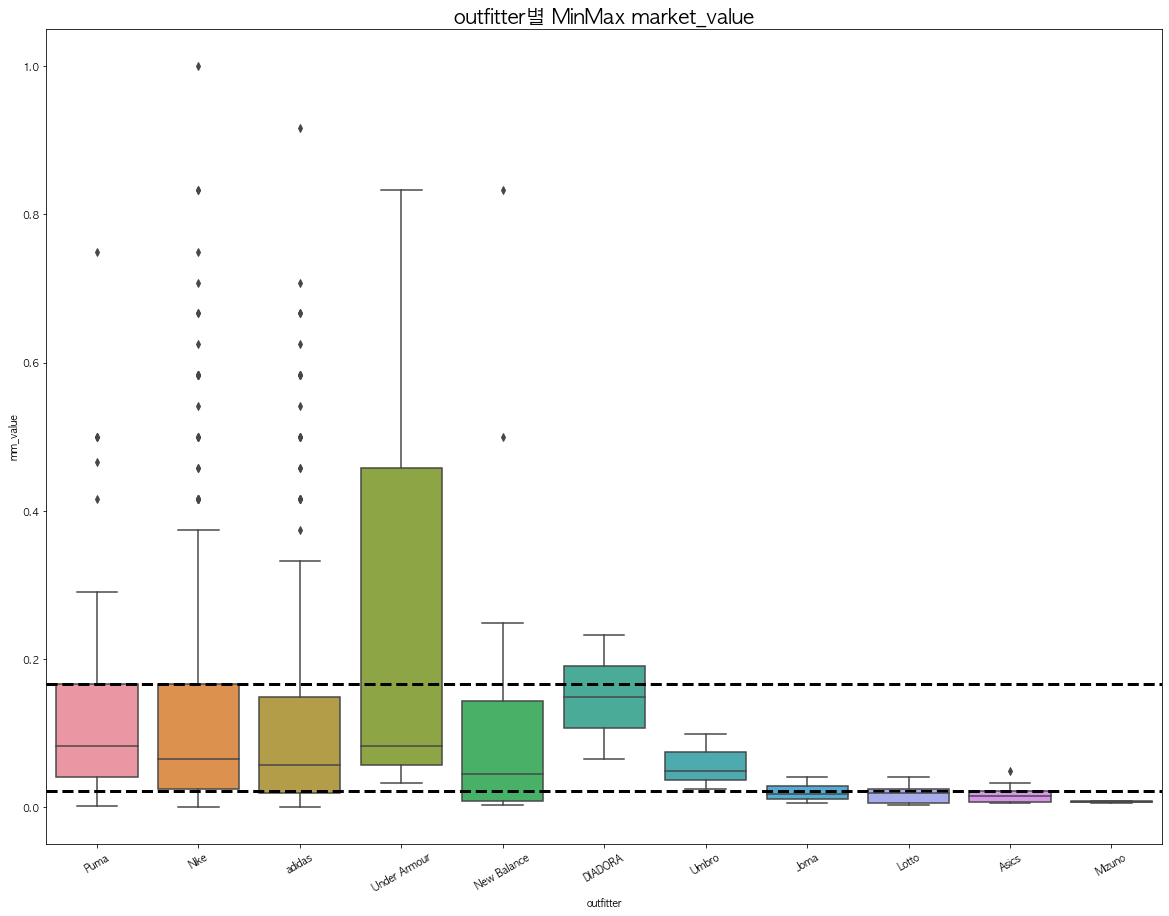

In [29]:
plt.figure(figsize=(20, 15))

sns.boxplot(data=df, x='outfitter', y='mm_value')
plt.xticks(rotation=30)
plt.axhline(np.percentile(df['mm_value'], 25), color='black', linestyle='--', linewidth=3)
plt.axhline(np.percentile(df['mm_value'], 75), color='black', linestyle='--', linewidth=3)
plt.title('outfitter별 MinMax market_value', fontsize=20)

plt.show()

- 방법 1.
- `Puma`, `Nike`, `adidas`, `Under Armour`, `New Balance, DIADORA, Umbro, Joma`, `Lotto, Asics, Mizuno`

In [30]:
df['outfitter'].unique()[4:8].tolist(), df['outfitter'].unique()[8:].tolist()

(['New Balance', 'DIADORA', 'Umbro', 'Joma'], ['Lotto', 'Asics', 'Mizuno'])

In [31]:
def convert_outfit(outfitter):
    if outfitter in df['outfitter'].unique()[4:8].tolist():
        data = "middle"
    elif outfitter in df['outfitter'].unique()[8:].tolist():
        data = "lower"
    else:
        data = outfitter
    return data

In [32]:
model_df = players_df.copy()
model_df['market_value'] = np.log1p(model_df['market_value'])
model_df['club'] = model_df['club'].apply(convert_club)
model_df['outfitter'] = model_df['outfitter'].apply(convert_outfit)

In [33]:
formula = "+".join([f"scale({var})" for var in cons_5] + [f"C({var})" for var in cate_5])
print(formula)

scale(app)+scale(conceded_goals)+scale(clean_sheets)+scale(yellow_card)+scale(age)+scale(height)+scale(sns)+scale(cup)+scale(Tackles)+scale(Inter)+scale(Fouls)+scale(Offsides)+scale(Clear)+scale(Drbed)+scale(Blocks)+scale(OwnG)+scale(Assists)+scale(KeyP)+scale(AvgP)+scale(PS)+scale(Crosses)+scale(LongB)+scale(ThrB)+scale(Rating)+scale(Goals)+scale(SpG)+scale(Drb)+scale(Fouled)+scale(Off)+scale(Disp)+scale(UnsTch)+scale(AerialsWon)+scale(MotM)+scale(period)+scale(club)+C(second_yell)+C(red_card)+C(position)+C(foot)+C(outfitter)


In [34]:
model_6, score_6 = get_scores(model_df, formula, get_model=True)
print()
compare_scores(score_5, score_6)

r-score : 0.695
mse : 0.5314
rmse : 0.7261

r-score 변화량:  -0.0007
mse 변화량 : 0.0013
rmse 변화량 : 0.0008


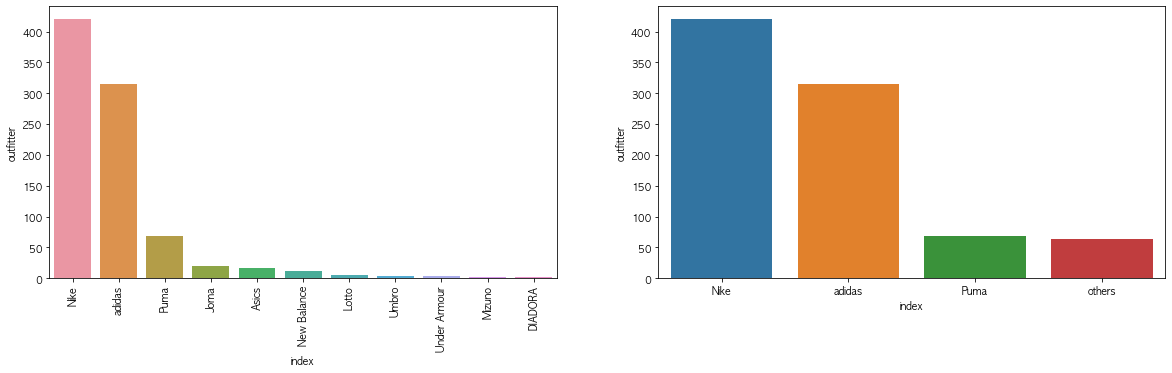

In [35]:
others_ls = players_df['outfitter'].unique()[3:].tolist()

plt.figure(figsize=(20, 5))

plt.subplot(121)
sns.barplot(data=df['outfitter'].value_counts().reset_index(),
            x='index', y='outfitter')
plt.xticks(rotation=90)

plt.subplot(122)
sns.barplot(data=df['outfitter'].apply(lambda x: "others" if x in others_ls else x).value_counts().reset_index(),
           x='index', y='outfitter')
df['outfitter'].apply(lambda x: "others" if x in others_ls else x).value_counts().reset_index()

plt.show()

- 방법 2
- 개수가 적은 class들을 others로 묶음

In [36]:
model_df = players_df.copy()
model_df['market_value'] = np.log1p(model_df['market_value'])
model_df['club'] = model_df['club'].apply(convert_club)
model_df['outfitter'] = model_df['outfitter'].apply(lambda x: "others" if x in others_ls else x)

In [37]:
formula = "+".join([f"scale({var})" for var in cons_5] + [f"C({var})" for var in cate_5])
print(formula)

scale(app)+scale(conceded_goals)+scale(clean_sheets)+scale(yellow_card)+scale(age)+scale(height)+scale(sns)+scale(cup)+scale(Tackles)+scale(Inter)+scale(Fouls)+scale(Offsides)+scale(Clear)+scale(Drbed)+scale(Blocks)+scale(OwnG)+scale(Assists)+scale(KeyP)+scale(AvgP)+scale(PS)+scale(Crosses)+scale(LongB)+scale(ThrB)+scale(Rating)+scale(Goals)+scale(SpG)+scale(Drb)+scale(Fouled)+scale(Off)+scale(Disp)+scale(UnsTch)+scale(AerialsWon)+scale(MotM)+scale(period)+scale(club)+C(second_yell)+C(red_card)+C(position)+C(foot)+C(outfitter)


In [38]:
model_6_2, score_6_2 = get_scores(model_df, formula, get_model=True)
print()
compare_scores(score_5, score_6_2)

r-score : 0.6978
mse : 0.5265
rmse : 0.7227

r-score 변화량:  0.0021
mse 변화량 : -0.0036
rmse 변화량 : -0.0026


-> model_5 보다 약간 성능 상승

- 방법 3
- outfitter 제거

In [39]:
model_df = players_df.copy()
model_df['market_value'] = np.log1p(model_df['market_value'])
model_df['club'] = model_df['club'].apply(convert_club)

In [40]:
cate_6 = cate_5.copy()
cate_6.remove('outfitter')

formula = "+".join([f"scale({var})" for var in cons_5] + [f"C({var})" for var in cate_6])
print(formula)

scale(app)+scale(conceded_goals)+scale(clean_sheets)+scale(yellow_card)+scale(age)+scale(height)+scale(sns)+scale(cup)+scale(Tackles)+scale(Inter)+scale(Fouls)+scale(Offsides)+scale(Clear)+scale(Drbed)+scale(Blocks)+scale(OwnG)+scale(Assists)+scale(KeyP)+scale(AvgP)+scale(PS)+scale(Crosses)+scale(LongB)+scale(ThrB)+scale(Rating)+scale(Goals)+scale(SpG)+scale(Drb)+scale(Fouled)+scale(Off)+scale(Disp)+scale(UnsTch)+scale(AerialsWon)+scale(MotM)+scale(period)+scale(club)+C(second_yell)+C(red_card)+C(position)+C(foot)


In [41]:
model_6_3, score_6_3 = get_scores(model_df, formula, get_model=True)
print()
compare_scores(score_6_2, score_6_3)

r-score : 0.7018
mse : 0.5198
rmse : 0.7181

r-score 변화량:  0.004
mse 변화량 : -0.0067
rmse 변화량 : -0.0046


- model_6_3의 방법이 성능이 가장 좋으므로 outfitter 삭제

In [152]:
sm.stats.anova_lm(model_6_3, model_5)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,651.0,283.150354,0.0,NaN,NaN,NaN
1,641.0,280.500999,10.0,2.649355,0.60543,0.809909


- model_6_3과 전 모델인 model_5 의 F검정 p-value값이 유의수준을 넘으므로 귀무가설을 기각 못함 > 두 모델이 같다고 볼 수 있음

In [45]:
print(model_6_3.summary())

                            OLS Regression Results                            
Dep. Variable:           market_value   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     48.21
Date:                Thu, 20 May 2021   Prob (F-statistic):          8.15e-171
Time:                        09:31:31   Log-Likelihood:                -673.66
No. Observations:                 694   AIC:                             1433.
Df Residuals:                     651   BIC:                             1629.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

## Model_7
- 범주형
    - club > 수치형 변수로 변환
        - 챔스 : 5, 유로파 : 3, 일반 : 0, 강등 : -3
    - outfitter 제거
    - second_yell, red_card 결합을 통한 파생변수 생성 : out
- 수치형
    - formula default scaling
- 종속변수
    - log scaling

In [46]:
model_df = players_df.copy()

In [47]:
model_df['second_yell'] = model_df['second_yell'].astype('int')
model_df['red_card'] = model_df['red_card'].astype('int')
model_df['out'] = model_df['red_card'] + model_df['second_yell']

model_df.drop(columns=['red_card', 'second_yell'], inplace=True)
model_df.tail(2)

,market_value,app,conceded_goals,clean_sheets,yellow_card,age,height,position,foot,club,outfitter,sns,cup,Tackles,Inter,Fouls,Offsides,Clear,Drbed,Blocks,OwnG,Assists,KeyP,AvgP,PS,Crosses,LongB,ThrB,Rating,Goals,SpG,Drb,Fouled,Off,Disp,UnsTch,AerialsWon,MotM,period,out
865,1080000,9,0.1,0.0,0.2,23,190,attack,right,Cádiz CF,Nike,1,3,0.1,0.1,1.6,0.0,0.4,0.2,0.0,0.0,6.48,1.0,0.0,1.2,0.0,1.8,0.4,0.8,0.1,9.0,72.8,0.0,0.0,0.0,3.4,0.0,0.6,1.5,0
866,1080000,34,0.2,0.1,0.1,35,186,attack,left,Cádiz CF,New Balance,2,6,0.3,0.1,0.6,0.1,0.6,0.2,0.1,0.0,6.73,7.0,4.0,1.4,0.6,1.1,0.2,0.6,0.0,16.0,57.1,0.0,0.6,0.1,3.7,4.0,0.9,1.1,1


In [48]:
model_df['out'].value_counts()

0    775
1     89
2      3
Name: out, dtype: int64

In [49]:
model_df['market_value'] = np.log1p(model_df['market_value'])
model_df['club'] = model_df['club'].apply(convert_club)

In [50]:
cate_7 = ["position", "foot"]
cons_7 = list(set(model_df.columns) - set(cate_7))
cons_7.remove('market_value')
cons_7.remove('outfitter')

In [51]:
formula = "+".join([f"scale({var})" for var in cons_7] + [f"C({var})" for var in cate_7])
print(formula)

scale(Off)+scale(Offsides)+scale(age)+scale(Rating)+scale(app)+scale(Inter)+scale(height)+scale(UnsTch)+scale(yellow_card)+scale(Crosses)+scale(Goals)+scale(Blocks)+scale(PS)+scale(OwnG)+scale(Assists)+scale(Tackles)+scale(club)+scale(cup)+scale(Drbed)+scale(period)+scale(conceded_goals)+scale(sns)+scale(Fouls)+scale(Clear)+scale(Drb)+scale(Fouled)+scale(ThrB)+scale(LongB)+scale(Disp)+scale(MotM)+scale(AerialsWon)+scale(out)+scale(clean_sheets)+scale(KeyP)+scale(SpG)+scale(AvgP)+C(position)+C(foot)


In [52]:
model_7, score_7 = get_scores(model_df, formula, get_model=True)
print()
compare_scores(score_6_3, score_7)

r-score : 0.7029
mse : 0.518
rmse : 0.7167

r-score 변화량:  0.0011
mse 변화량 : -0.0018
rmse 변화량 : -0.0014


- second_yell, red_card 두 컬럼을 합쳤을 때 전 모델보다 성능 약간 향상

In [153]:
sm.stats.anova_lm(model_7, model_6_3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,652.0,283.251295,0.0,NaN,NaN,NaN
1,651.0,283.150354,1.0,0.100941,0.232076,0.63015


In [53]:
print(model_7.summary())

                            OLS Regression Results                            
Dep. Variable:           market_value   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     49.44
Date:                Thu, 20 May 2021   Prob (F-statistic):          1.29e-171
Time:                        09:31:40   Log-Likelihood:                -673.78
No. Observations:                 694   AIC:                             1432.
Df Residuals:                     652   BIC:                             1622.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

### VIF를 사용한 변수 제거

In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

dfX, score_7 = get_scores(model_df, formula, show_dfX=True)

vif_df = pd.DataFrame()
vif_df["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.shape[1])]
vif_df["features"] = dfX.columns

r-score : 0.7029
mse : 0.518
rmse : 0.7167


#### VIF 값이 5가 넘는 변수들 중에 다중공선성이 크고 영향력이 적은 변수 추출

In [60]:
vif_df = vif_df.sort_values('VIF Factor', ascending=False).reset_index(drop=True)
vif_df[vif_df['VIF Factor'] > 5]

,VIF Factor,features
0,75.401205,scale(Rating)
1,59.499529,scale(PS)
2,53.572963,Intercept
3,49.032170,scale(Drb)
4,12.804840,scale(Assists)
5,12.738709,C(position)[T.Goalkeeper]
6,9.859369,scale(SpG)
7,9.642916,C(foot)[T.left]
8,9.608185,C(foot)[T.right]
9,8.826612,scale(AvgP)


- 제거
    - 연속형 : Rating, PS, Drb, Assists, Clear, Off
    - 범주형 : position, foot
- SpG, AvgP conceded_goals : vif 값은 높지만 p-value가 낮고 의미있는 변수기에 제거x

### KMeans를 사용한 제거변수 clustering

In [61]:
remove_df = players_df.copy()
remove_df = remove_df[["position", "foot", "Rating", "PS", "Drb", "Assists", "Clear", "Off"]]
remove_df.tail()

,position,foot,Rating,PS,Drb,Assists,Clear,Off
862,attack,right,0.6,0.6,67.3,6.32,0.3,0.2
863,attack,right,0.4,0.3,59.2,6.10,0.0,0.2
864,attack,right,0.6,0.6,74.6,6.71,0.7,0.2
865,attack,right,0.8,1.2,72.8,6.48,0.4,0.0
866,attack,left,0.6,1.4,57.1,6.73,0.6,0.6


In [62]:
remove_df = pd.get_dummies(remove_df, columns=['position', 'foot'], drop_first=True)
remove_df.tail()

,Rating,PS,Drb,Assists,Clear,Off,position_Goalkeeper,position_attack,position_midfield,foot_left,foot_right
862,0.6,0.6,67.3,6.32,0.3,0.2,0,1,0,0,1
863,0.4,0.3,59.2,6.10,0.0,0.2,0,1,0,0,1
864,0.6,0.6,74.6,6.71,0.7,0.2,0,1,0,0,1
865,0.8,1.2,72.8,6.48,0.4,0.0,0,1,0,0,1
866,0.6,1.4,57.1,6.73,0.6,0.6,0,1,0,1,0


In [63]:
remove_df.iloc[:, :6].values

array([[ 6.57, 81.7 ,  0.  ,  1.  ,  0.5 ,  0.  ],
       [ 6.07, 80.8 ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 6.95, 93.4 ,  0.2 ,  0.  ,  2.8 ,  0.  ],
       ...,
       [ 0.6 ,  0.6 , 74.6 ,  6.71,  0.7 ,  0.2 ],
       [ 0.8 ,  1.2 , 72.8 ,  6.48,  0.4 ,  0.  ],
       [ 0.6 ,  1.4 , 57.1 ,  6.73,  0.6 ,  0.6 ]])

In [64]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit_transform(remove_df.iloc[:, :6].values)

In [65]:
remove_df[["Rating", "PS", "Drb", "Assists", "Clear", "Off"]] = ss

In [66]:
remove_df.tail()

,Rating,PS,Drb,Assists,Clear,Off,position_Goalkeeper,position_attack,position_midfield,foot_left,foot_right
862,-0.971783,-0.994232,0.738196,0.813432,-0.726908,-0.472066,0,1,0,0,1
863,-1.036526,-1.001776,0.530340,0.739636,-0.972292,-0.472066,0,1,0,0,1
864,-0.971783,-0.994232,0.925524,0.944253,-0.399728,-0.472066,0,1,0,0,1
865,-0.907039,-0.979145,0.879333,0.867102,-0.645113,-0.589473,0,1,0,0,1
866,-0.971783,-0.974116,0.476451,0.950962,-0.481523,-0.237252,0,1,0,1,0


In [67]:
from sklearn.cluster import KMeans

distance = []
for i in range(2, 15):
    model = KMeans(n_clusters=i).fit(remove_df)
    distance.append(model.inertia_)

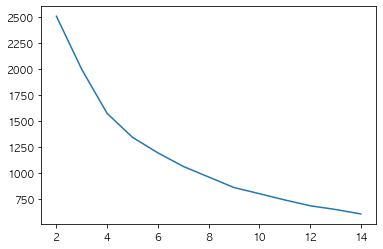

In [68]:
sns.lineplot(x=list(range(2, 15)), y=distance);

In [69]:
from sklearn.metrics import silhouette_score

sil = []
for i in range(2, 15):
    model = KMeans(n_clusters=i).fit(remove_df)
    sil.append(silhouette_score(remove_df, model.labels_))

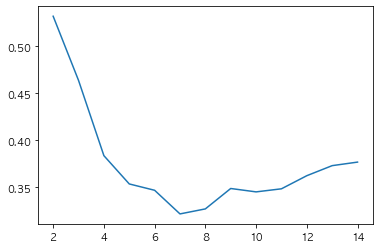

In [70]:
sns.lineplot(x=list(range(2, 15)), y=sil);

#### n_clusters=2 일 때 실루엣 계수가 가장 높음

In [72]:
model = KMeans(n_clusters=2).fit(remove_df)

In [75]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

datas = pca.fit_transform(remove_df)

pca_df = pd.DataFrame(datas, columns=["PC1", "PC2"])
pca_df

,PC1,PC2
0,-2.009136,-0.547109
1,-2.046947,-0.779620
2,-2.521959,1.178803
3,-2.366053,0.405497
4,-2.381599,0.241208
...,...,...
862,1.586626,-1.036098
863,1.508219,-1.237501
864,1.709446,-0.768155
865,1.597006,-1.020968


In [76]:
pca_df['label'] = model.labels_

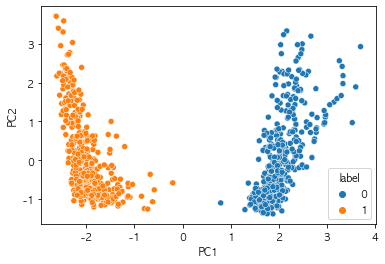

In [77]:
sns.scatterplot(data=pca_df, x='PC1', y="PC2", hue='label');

In [78]:
remove_df['label'] = model.labels_

In [79]:
remove_df

,Rating,PS,Drb,Assists,Clear,Off,position_Goalkeeper,position_attack,position_midfield,foot_left,foot_right,label
0,0.960817,1.045018,-0.988810,-0.971100,-0.563318,-0.589473,1,0,0,1,0,1
1,0.798957,1.022387,-0.988810,-1.306538,-0.972292,-0.589473,1,0,0,0,1,1
2,1.083830,1.339213,-0.983678,-1.306538,1.317962,-0.589473,0,0,0,0,1,1
3,1.012612,1.271322,-0.986244,-1.306538,0.500014,-0.530769,0,0,0,1,0,1
4,0.973765,1.329155,-0.988810,-1.306538,0.336425,-0.589473,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
862,-0.971783,-0.994232,0.738196,0.813432,-0.726908,-0.472066,0,1,0,0,1,0
863,-1.036526,-1.001776,0.530340,0.739636,-0.972292,-0.472066,0,1,0,0,1,0
864,-0.971783,-0.994232,0.925524,0.944253,-0.399728,-0.472066,0,1,0,0,1,0
865,-0.907039,-0.979145,0.879333,0.867102,-0.645113,-0.589473,0,1,0,0,1,0


## Model_8
- 범주형
    - club > 수치형 변수로 변환
        - 챔스 : 5, 유로파 : 3, 일반 : 0, 강등 : -3
    - outfitter 제거
    - second_yell, red_card 결합을 통한 파생변수 생성 : out (수치형)
- 수치형
    - formula default scaling
- 종속변수
    - log scaling
    
- VIF로 추출한 독립변수들의 KMeans clustering 을 통한 파생변수 생성 : label (범주형)

In [88]:
model_df = players_df.copy()

model_df['second_yell'] = model_df['second_yell'].astype('int')
model_df['red_card'] = model_df['red_card'].astype('int')
model_df['out'] = model_df['red_card'] + model_df['second_yell']
model_df.drop(columns=['red_card', 'second_yell', "outfitter"], inplace=True)

model_df['market_value'] = np.log1p(model_df['market_value'])
model_df['club'] = model_df['club'].apply(convert_club)

In [89]:
remove_ls = remove_df.columns[:6].tolist() + ['position', 'foot']
model_df.drop(columns=remove_ls, inplace=True)

model_df['label'] = model.labels_

In [90]:
model_df.tail()

,market_value,app,conceded_goals,clean_sheets,yellow_card,age,height,club,sns,cup,Tackles,Inter,Fouls,Offsides,Drbed,Blocks,OwnG,KeyP,AvgP,Crosses,LongB,ThrB,Goals,SpG,Fouled,Disp,UnsTch,AerialsWon,MotM,period,out,label
862,13.892473,22,0.0,0.0,0.2,26,186,0,1,0,0.6,0.1,1.3,0.0,0.9,0.0,0.0,1.0,1.0,0.5,1.0,0.2,0.1,7.2,0.6,0.0,0.6,1.0,0.6,5.5,0,0
863,13.710151,27,0.0,0.1,0.1,28,182,0,1,0,0.4,0.1,0.6,0.0,0.4,0.0,0.0,0.0,1.0,0.1,0.5,0.3,0.0,5.4,0.1,0.0,0.4,0.0,0.3,3.5,0,0
864,14.115616,20,0.0,0.0,0.1,28,185,0,2,1,1.6,0.9,1.1,0.0,0.5,0.0,0.0,1.0,0.0,0.7,1.7,0.3,0.1,14.9,0.1,0.0,2.1,1.0,0.0,1.5,0,0
865,13.892473,9,0.1,0.0,0.2,23,190,0,1,3,0.1,0.1,1.6,0.0,0.2,0.0,0.0,1.0,0.0,0.0,1.8,0.4,0.1,9.0,0.0,0.0,3.4,0.0,0.6,1.5,0,0
866,13.892473,34,0.2,0.1,0.1,35,186,0,2,6,0.3,0.1,0.6,0.1,0.2,0.1,0.0,7.0,4.0,0.6,1.1,0.2,0.0,16.0,0.0,0.1,3.7,4.0,0.9,1.1,1,0


In [91]:
formula = "+".join([f"scale({var})" for var in model_df.columns.tolist()[1:-1]]) + "+C(label)"
print(formula)

scale(app)+scale(conceded_goals)+scale(clean_sheets)+scale(yellow_card)+scale(age)+scale(height)+scale(club)+scale(sns)+scale(cup)+scale(Tackles)+scale(Inter)+scale(Fouls)+scale(Offsides)+scale(Drbed)+scale(Blocks)+scale(OwnG)+scale(KeyP)+scale(AvgP)+scale(Crosses)+scale(LongB)+scale(ThrB)+scale(Goals)+scale(SpG)+scale(Fouled)+scale(Disp)+scale(UnsTch)+scale(AerialsWon)+scale(MotM)+scale(period)+scale(out)+C(label)


In [92]:
model_8, score_8 = get_scores(model_df, formula, get_model=True)
print()
compare_scores(score_7, score_8)

r-score : 0.7034
mse : 0.5183
rmse : 0.7158

r-score 변화량:  0.0005
mse 변화량 : 0.0003
rmse 변화량 : -0.0009


In [86]:
print(model_8.summary())

                            OLS Regression Results                            
Dep. Variable:           market_value   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     63.29
Date:                Thu, 20 May 2021   Prob (F-statistic):          2.30e-175
Time:                        09:33:10   Log-Likelihood:                -686.26
No. Observations:                 694   AIC:                             1437.
Df Residuals:                     662   BIC:                             1582.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                15.25

In [155]:
sm.stats.anova_lm(model_8, model_7)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,662.0,293.619569,0.0,NaN,NaN,NaN
1,652.0,283.251295,10.0,10.368274,2.386614,0.008788


-> model_7과 비교하였을 때 귀무가설을 기각하므로 두 모델을 다르다고 볼 수 있다.

#### 각 독립변수들과 종속변수간의 부분회귀 플롯

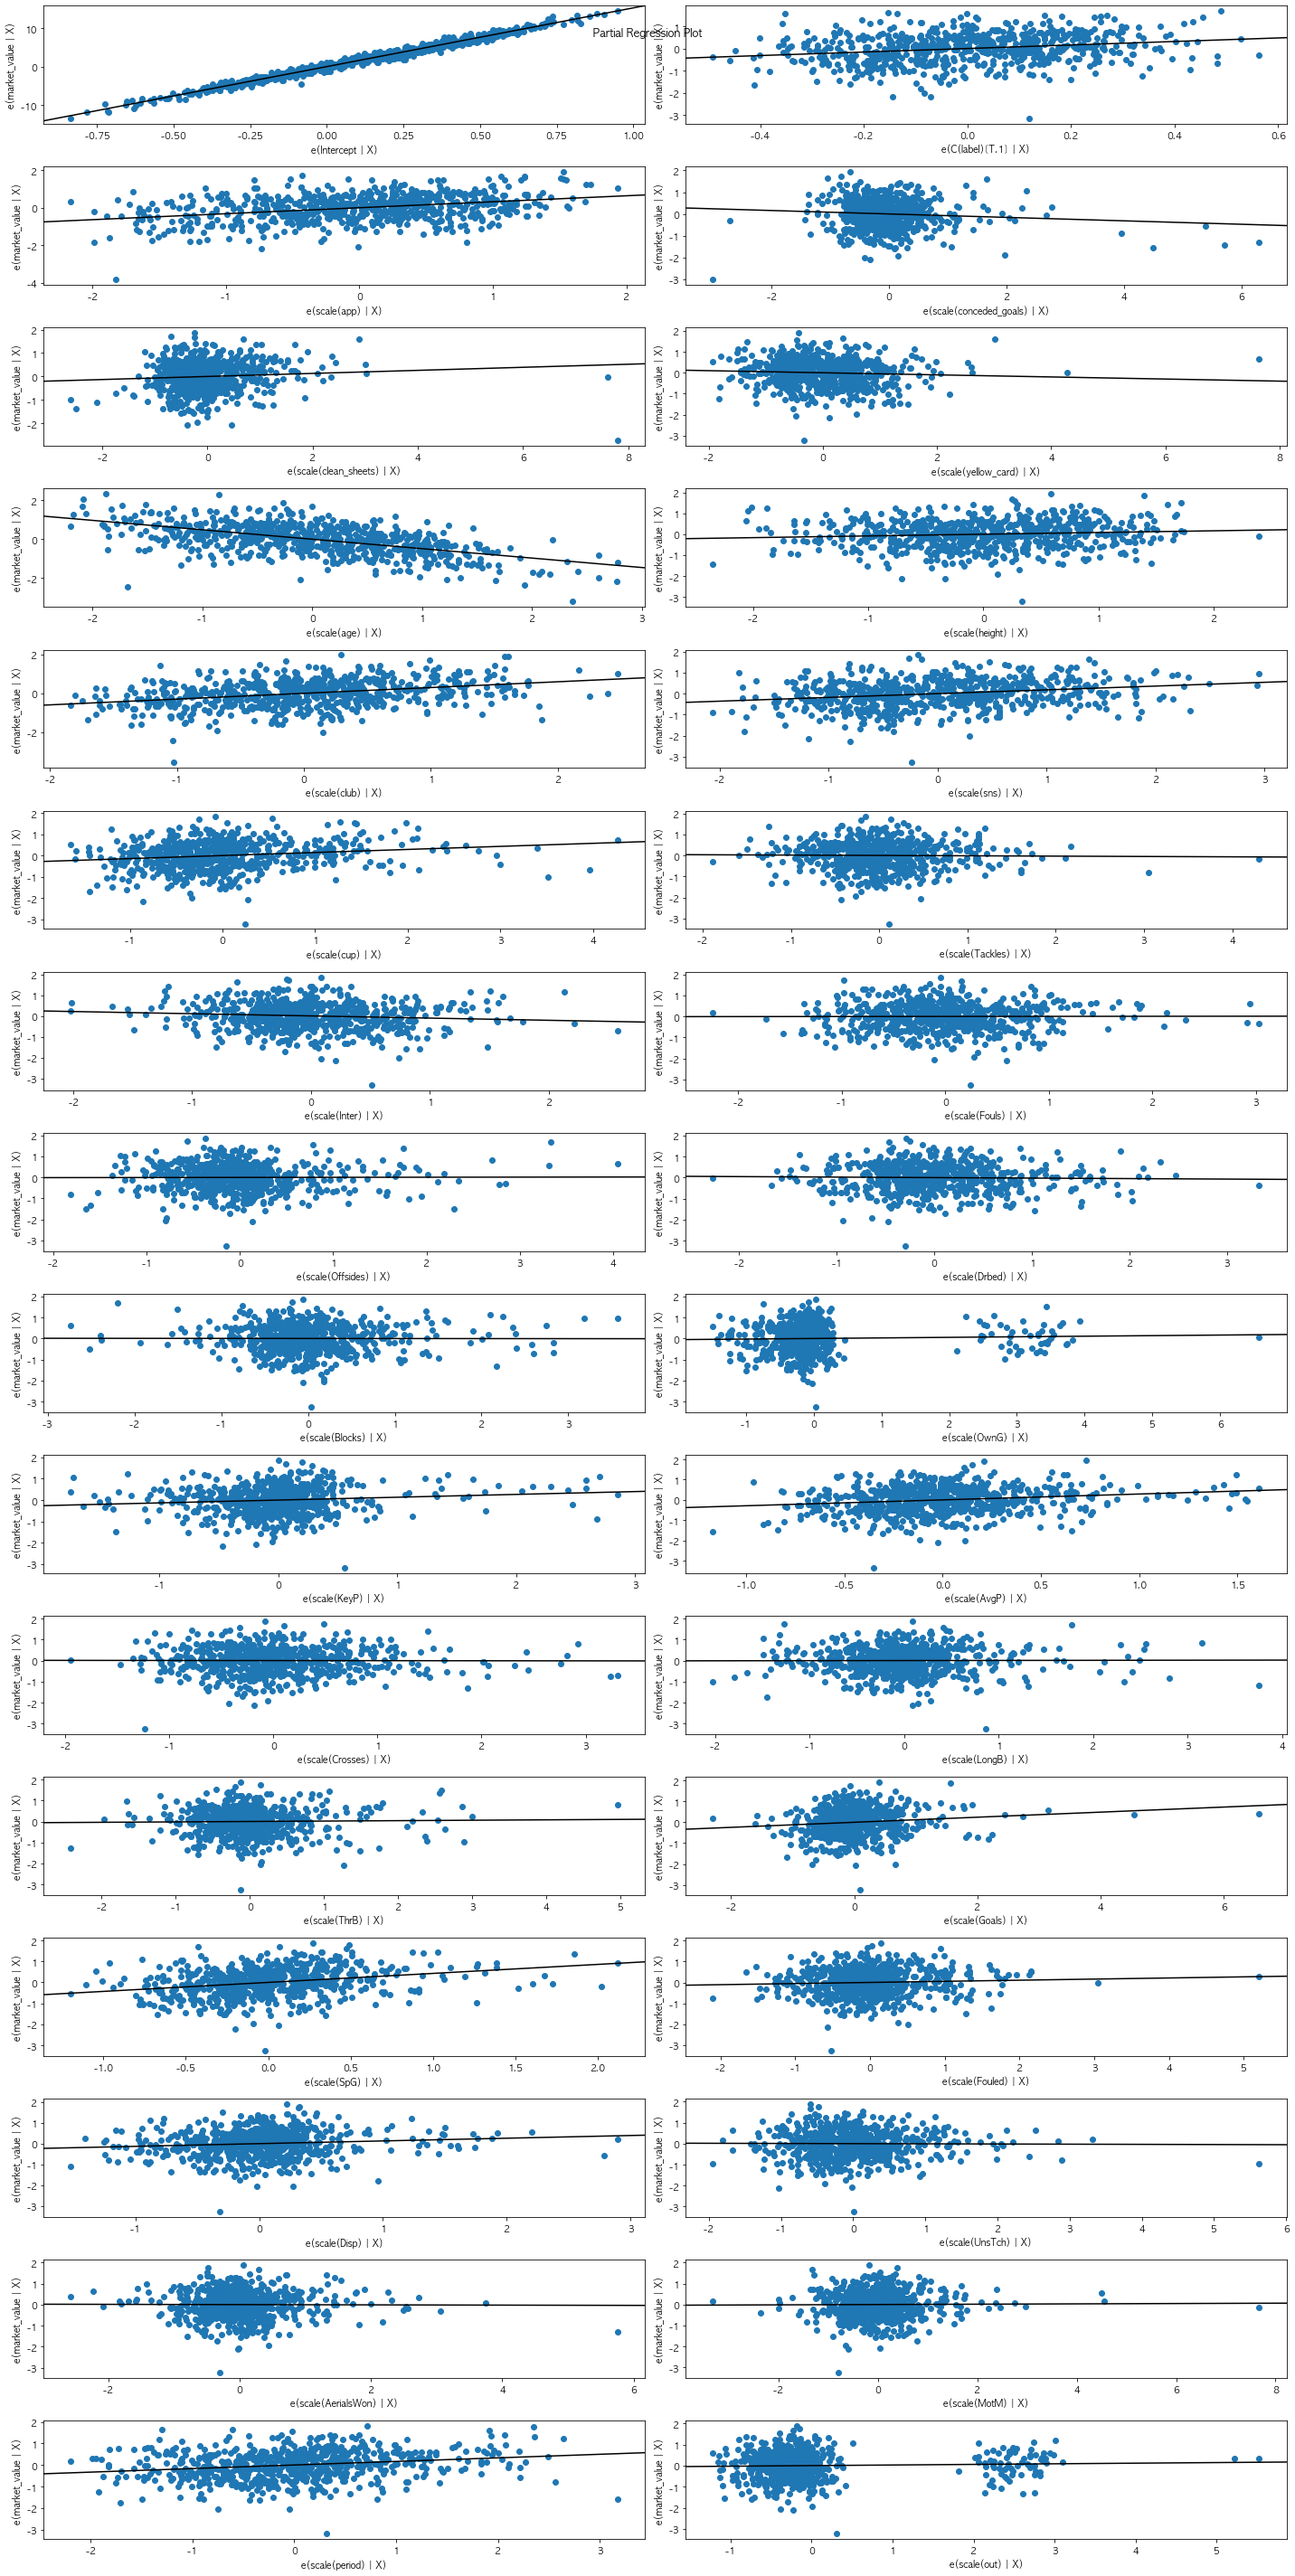

In [149]:
fig = plt.figure(figsize=(20, 40))
# 전체 데이터에 대해 한번에 부분회귀 플롯
sm.graphics.plot_partregress_grid(model_8, fig=fig)

plt.tight_layout()
plt.show()

## Model의 아웃라이어

### Cook's distance 공식을 이용한 모델의 레버리지 도출
- 5번의 교차검증을 통한 아웃라이어 도출
- 2번 이상 선정된 인덱스에 한해 아웃라이어로 판단

In [102]:
df_X = dmatrix(formula, model_df, return_type='dataframe')
df_y = model_df['market_value']

outlier_ls = []
cv = KFold(5, shuffle=True, random_state=3)
for i, (idx_train, idx_test) in enumerate(cv.split(model_df)):
    
    X_train, X_test = df_X.iloc[idx_train], df_X.iloc[idx_test]
    y_train, y_test = df_y.iloc[idx_train], df_y.iloc[idx_test]
    
    model = sm.OLS(y_train, X_train).fit()
    influence_model = model.get_influence()
    cooks_d2, pvals = influence_model.cooks_distance
    
    K = influence_model.k_vars
    fox_cr = 4 / (len(X_train) - K - 1)
    
    idx = np.where(cooks_d2 > fox_cr)[0].tolist()
    outlier_ls.extend(idx)
    
print(outlier_ls)

[21, 41, 86, 106, 107, 120, 127, 156, 264, 309, 312, 355, 359, 360, 365, 396, 402, 444, 466, 467, 470, 512, 514, 546, 556, 560, 562, 599, 645, 653, 658, 678, 18, 20, 40, 44, 94, 105, 110, 111, 135, 145, 165, 177, 265, 295, 309, 312, 354, 355, 392, 399, 435, 449, 470, 516, 518, 559, 571, 576, 579, 636, 659, 670, 679, 9, 39, 42, 86, 109, 125, 155, 160, 172, 175, 269, 301, 318, 322, 358, 361, 363, 381, 391, 399, 449, 463, 508, 510, 558, 565, 567, 602, 631, 645, 653, 654, 658, 670, 676, 693, 17, 38, 41, 90, 114, 131, 136, 265, 294, 314, 351, 357, 358, 362, 390, 397, 465, 468, 512, 554, 562, 565, 573, 610, 637, 652, 659, 660, 674, 18, 36, 46, 117, 118, 133, 140, 168, 309, 328, 365, 370, 376, 377, 382, 410, 456, 457, 464, 477, 478, 481, 525, 554, 555, 572, 602, 646, 653, 654, 658, 667, 676]


In [150]:
idx_df = pd.DataFrame(np.array(outlier_ls))[0].value_counts().reset_index()
idx_df.head()

,index,0
0,309,3
1,658,3
2,653,3
3,562,2
4,654,2


In [104]:
outlier_idx = idx_df[idx_df[0]  >= 2]['index'].tolist()
print(outlier_idx)

[309, 658, 653, 562, 654, 399, 659, 358, 355, 512, 470, 312, 449, 602, 670, 86, 41, 676, 365, 565, 645, 265, 18, 554]


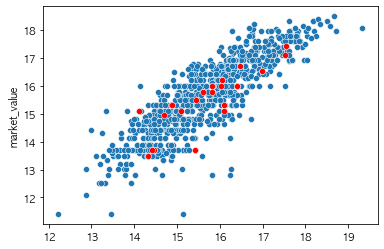

In [107]:
pred = model_8.predict(df_X)

pred.iloc[outlier_idx].values

sns.scatterplot(x=pred, y=df_y);
sns.scatterplot(x=pred.iloc[outlier_idx].values, y=df_y.iloc[outlier_idx].values, color='r');

#### 1. 최종 모델의 성능 평가

In [111]:
from sklearn.model_selection import train_test_split

df_X = dmatrix(formula, model_df, return_type='dataframe')
df_y = model_df['market_value']

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=3)

In [113]:
test_model_1 = sm.OLS(y_train, X_train).fit()

pred_1 = test_model_1.predict(X_test)

In [115]:
mse = metrics.mean_squared_error(y_test, pred_1)
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred_1))
r_squared = r2_score(y_test, pred_1)

print("r2-score : {}, mse : {}, rmse : {}".format(r_squared.round(4), mse.round(4), rmse.round(4)))

r2-score : 0.7425, mse : 0.4196, rmse : 0.6477


#### 2. Cook's distance를 통한 아웃라이어 제거한 모델의 성능 평가

In [116]:
df_X2 = df_X.drop(index=outlier_idx)
df_y2 = df_y.drop(index=outlier_idx)

X_train, X_test, y_train, y_test = train_test_split(df_X2, df_y2, test_size=0.3, random_state=3)

In [118]:
test_model_2 = sm.OLS(y_train, X_train).fit()

pred_2 = test_model_2.predict(X_test)

mse = metrics.mean_squared_error(y_test, pred_2)
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred_2))
r_squared = r2_score(y_test, pred_2)

print("r2-score : {}, mse : {}, rmse : {}".format(r_squared.round(4), mse.round(4), rmse.round(4)))

r2-score : 0.6976, mse : 0.5157, rmse : 0.7181


#### 3. boxplot을 통한 아웃라이어 제거한 모델의 성능 평가

In [119]:
boxplot_outlier_idx = [0, 2, 3, 9, 12, 14, 15, 16, 17, 19, 21, 24, 31, 33, 35, 42, 44, 46, 53, 59, 62, 63, 65, 67, 81, 85, 87, 89, 90, 105, 110, 128, 144, 148, 152, 174, 188, 213, 230, 437, 447, 450, 452, 453, 454, 456, 458, 466, 467, 468, 474, 478, 480, 484, 485, 486, 497, 498, 533, 542]

In [120]:
df_X3 = df_X.drop(index=boxplot_outlier_idx)
df_y3 = df_y.drop(index=boxplot_outlier_idx)

X_train, X_test, y_train, y_test = train_test_split(df_X3, df_y3, test_size=0.3, random_state=3)

In [121]:
test_model_3 = sm.OLS(y_train, X_train).fit()

pred_3 = test_model_3.predict(X_test)

mse = metrics.mean_squared_error(y_test, pred_3)
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred_3))
r_squared = r2_score(y_test, pred_3)

print("r2-score : {}, mse : {}, rmse : {}".format(r_squared.round(4), mse.round(4), rmse.round(4)))

r2-score : 0.6151, mse : 0.5691, rmse : 0.7544


- outlier를 제거하지 않은 모델의 성능이 좋았음

### 정규화 회귀모형
- Ridge, Lasso 정규화모델

In [132]:
model_8_2 = sm.OLS.from_formula("np.log1p(market_value) ~ " + formula, data=model_df)

In [133]:
alpha_1 = -0.01
alpha_2 = 0.01
# Ridge
result_1 = model_8_2.fit_regularized(alpha=alpha_1, L1_wt=0)
result_11 = model_8_2.fit_regularized(alpha=alpha_2, L1_wt=0)

# Lasso
result_2 = model_8_2.fit_regularized(alpha=alpha_1, L1_wt=1)
result_22 = model_8_2.fit_regularized(alpha=alpha_2, L1_wt=1)

# middle
result_3 = model_8_2.fit_regularized(alpha=alpha_1, L1_wt=0.5)
result_33 = model_8_2.fit_regularized(alpha=alpha_2, L1_wt=0.5)

In [134]:
weight_df_1 = pd.DataFrame(columns=["origin", 'ridge', 'lasso', 'middle'])
weight_df_2 = pd.DataFrame(columns=["origin", 'ridge', 'lasso', 'middle'])

In [135]:
weight_df_1['origin'] = model_8.params
weight_df_1['ridge'] = result_1.params
weight_df_1['lasso'] = result_2.params
weight_df_1['middle'] = result_3.params
weight_df_1.reset_index(inplace=True)

intercept_df_1 = weight_df_1.iloc[0, :]
intercept_df_1 = intercept_df_1.iloc[1:]
weight_df_1 = weight_df_1.iloc[1:, :]


weight_df_2['origin'] = model_8.params
weight_df_2['ridge'] = result_11.params
weight_df_2['lasso'] = result_22.params
weight_df_2['middle'] = result_33.params
weight_df_2.reset_index(inplace=True)

intercept_df_2 = weight_df_2.iloc[0, :]
intercept_df_2 = intercept_df_2.iloc[1:]
weight_df_2 = weight_df_2.iloc[1:, :]

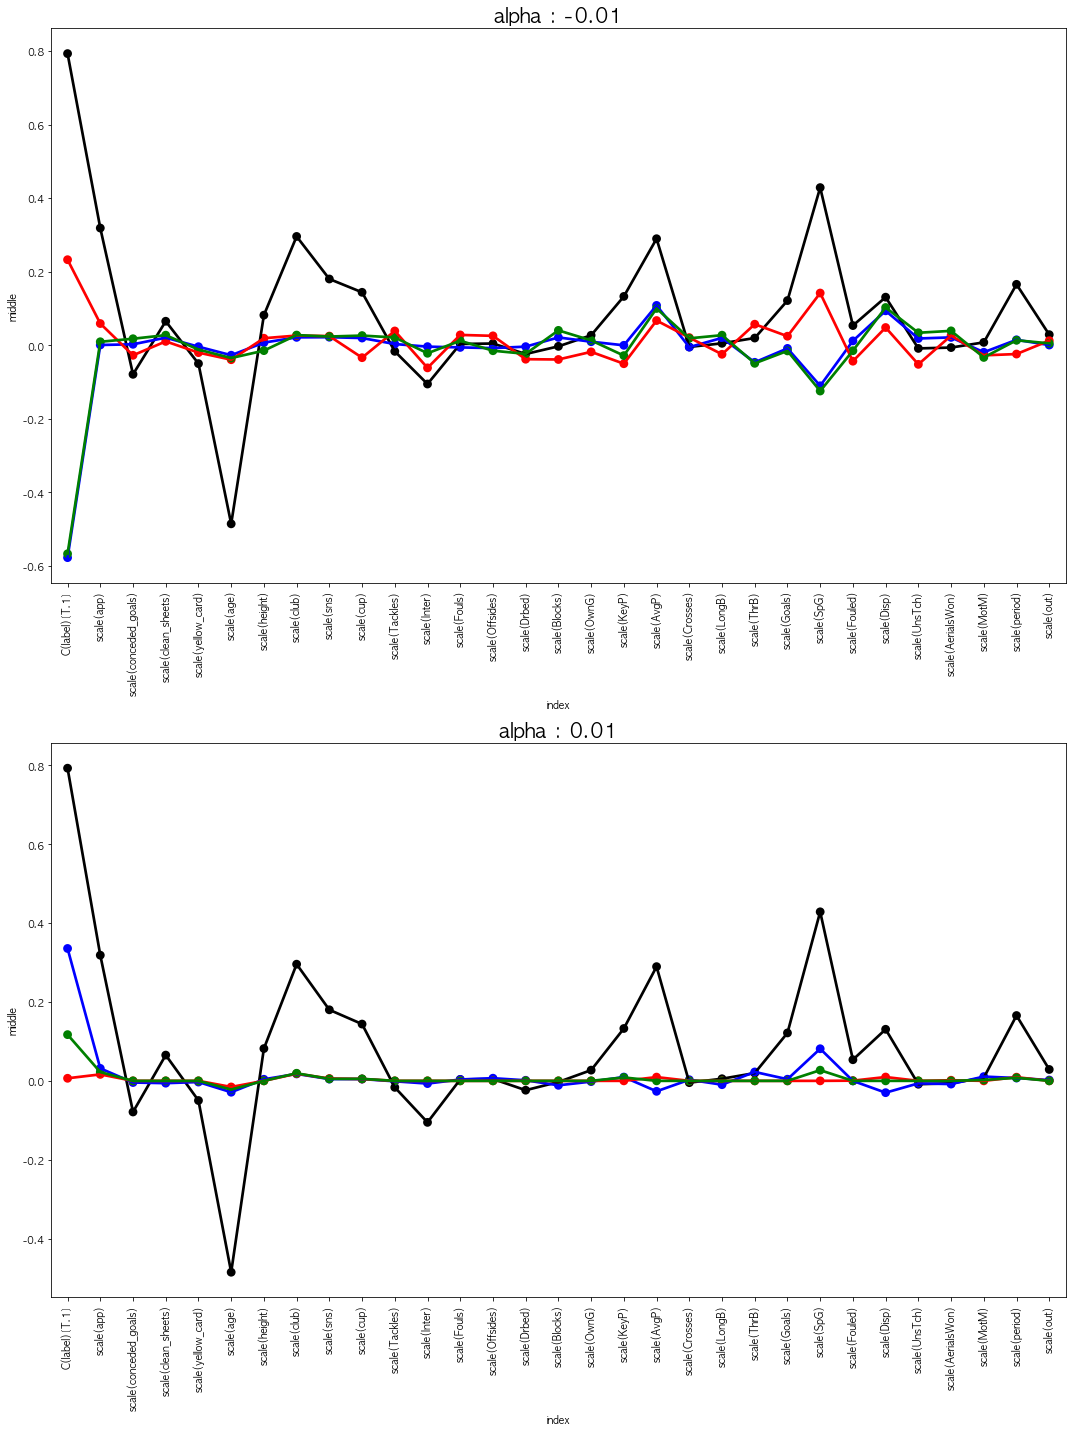

In [136]:
plt.figure(figsize=(15, 20))

plt.subplot(211)
sns.pointplot(data=weight_df_1, x='index', y='origin', color='black')
sns.pointplot(data=weight_df_1, x='index', y='ridge', color='b')
sns.pointplot(data=weight_df_1, x='index', y='lasso', color='r')
sns.pointplot(data=weight_df_1, x='index', y='middle', color='g')
plt.xticks(rotation=90)
plt.title("alpha : -0.01", fontsize=20)

plt.subplot(212)
sns.pointplot(data=weight_df_2, x='index', y='origin', color='black')
sns.pointplot(data=weight_df_2, x='index', y='ridge', color='b')
sns.pointplot(data=weight_df_2, x='index', y='lasso', color='r')
sns.pointplot(data=weight_df_2, x='index', y='middle', color='g')
plt.xticks(rotation=90)
plt.title("alpha : 0.01", fontsize=20)

plt.tight_layout()
plt.show()

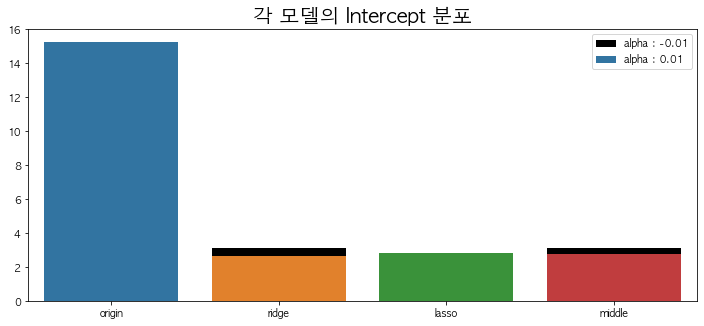

In [137]:
plt.figure(figsize=(12, 5))


sns.barplot(x=intercept_df_1.index, y=intercept_df_1.values, color='black', label="alpha : -0.01")
sns.barplot(x=intercept_df_2.index, y=intercept_df_2.values, label="alpha : 0.01")
plt.title("각 모델의 Intercept 분포", fontsize=20)

plt.legend()
plt.show()

## 최종 Model GridSearch - RandomForest

In [93]:
from sklearn.model_selection import train_test_split

df_X = dmatrix(formula, model_df, return_type='dataframe')
df_y = model_df['market_value']

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=3)

In [96]:
from sklearn.model_selection import GridSearchCV

random_params = {'bootstrap': [True, False],
 'max_depth': [1,3,5,7,9],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800]}

randomfr_tuning_model = GridSearchCV(
    randomfr_model,
    param_grid=random_params,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=3)

randomfr_tuning_model.fit(X_train,y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits
[CV 1/3] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1.085 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1.129 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1.406 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.098 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.116 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.413 total time=   0.2s
[CV 1/3] END boots

[CV 1/3] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-1.089 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-1.128 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-1.411 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.095 total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.120 total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.411 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, m

[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1.463 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.278 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.151 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.483 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.299 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.138 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, m

[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-1.469 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.293 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.140 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.473 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.341 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.143 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2,

[CV 1/3] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.721 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.775 total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.872 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.725 total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.779 total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.873 total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, m

[CV 1/3] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.719 total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.779 total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.866 total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.712 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.782 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.873 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2

[CV 2/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.833 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.949 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.876 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.835 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.957 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.859 total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, m

[CV 2/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.829 total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.950 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.853 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.833 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.944 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.855 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=

[CV 2/3] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.660 total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.682 total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.624 total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.669 total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.689 total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.635 total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, m

[CV 2/3] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.666 total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.689 total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.637 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.660 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.692 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.629 total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=

[CV 2/3] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.734 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.766 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.720 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.723 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.767 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.713 total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, m

[CV 2/3] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.727 total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.755 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.722 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.732 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.775 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.712 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=

[CV 2/3] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.631 total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.650 total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.606 total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.628 total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.647 total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.602 total time=   1.2s
[CV 2/3] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, m

[CV 2/3] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.634 total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.640 total time=   1.2s
[CV 1/3] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.604 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.647 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.636 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.598 total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=

[CV 2/3] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.683 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.702 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.657 total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.678 total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.699 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.658 total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, m

[CV 2/3] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.677 total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.701 total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.660 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.683 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.716 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.667 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=

[CV 2/3] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.620 total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.639 total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.587 total time=   1.1s
[CV 2/3] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.612 total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.635 total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.589 total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, m

[CV 2/3] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.619 total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.639 total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.589 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.643 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.633 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.588 total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=

[CV 2/3] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.666 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.680 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.642 total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.668 total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.679 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.630 total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, m

[CV 2/3] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.668 total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.681 total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.647 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.675 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.694 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.648 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=

[CV 2/3] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.294 total time=   0.2s
[CV 3/3] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.495 total time=   0.2s
[CV 1/3] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.179 total time=   0.3s
[CV 2/3] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.294 total time=   0.3s
[CV 3/3] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.495 total time=   0.3s
[CV 1/3] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-1.179 total time=   0.4s
[CV 2/3] END bootstrap=False, max_depth=1, max_features=auto, min_samples_le

[CV 2/3] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.294 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.495 total time=   0.4s
[CV 1/3] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.179 total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.294 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.495 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-1.179 total time=   0.2s
[CV 2/3] END bootstrap=False, max_depth=1, max_features=auto, min_sample

[CV 3/3] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.474 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.300 total time=   0.2s
[CV 2/3] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.146 total time=   0.2s
[CV 3/3] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.466 total time=   0.2s
[CV 1/3] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-1.303 total time=   0.3s
[CV 2/3] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-1.143 total time=   0.3s
[CV 3/3] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_le

[CV 3/3] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.473 total time=   0.2s
[CV 1/3] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.267 total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.145 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.462 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-1.292 total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-1.150 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=1, max_features=sqrt, min_sampl

[CV 3/3] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.018 total time=   0.4s
[CV 1/3] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.932 total time=   0.6s
[CV 2/3] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.024 total time=   0.6s
[CV 3/3] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.018 total time=   0.6s
[CV 1/3] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.932 total time=   0.8s
[CV 2/3] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-1.024 total time=   0.8s
[CV 3/3] END bootstrap=False, max_depth=3, max_features=auto, min_samples_le

[CV 3/3] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.018 total time=   0.8s
[CV 1/3] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.932 total time=   0.2s
[CV 2/3] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.024 total time=   0.2s
[CV 3/3] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.029 total time=   0.2s
[CV 1/3] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.932 total time=   0.4s
[CV 2/3] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-1.024 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=3, max_features=auto, min_sampl

[CV 1/3] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.863 total time=   0.2s
[CV 2/3] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.839 total time=   0.2s
[CV 3/3] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.953 total time=   0.2s
[CV 1/3] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.858 total time=   0.3s
[CV 2/3] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.838 total time=   0.3s
[CV 3/3] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.952 total time=   0.4s
[CV 1/3] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_le

[CV 3/3] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.961 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.843 total time=   0.2s
[CV 2/3] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.838 total time=   0.2s
[CV 3/3] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.942 total time=   0.2s
[CV 1/3] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.864 total time=   0.2s
[CV 2/3] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.848 total time=   0.2s
[CV 3/3] END bootstrap=False, max_depth=3, max_features=sqrt, min_samp

[CV 3/3] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.001 total time=   0.9s
[CV 1/3] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.995 total time=   1.2s
[CV 2/3] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.922 total time=   1.2s
[CV 3/3] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-1.001 total time=   1.2s
[CV 1/3] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.993 total time=   0.3s
[CV 2/3] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.924 total time=   0.3s
[CV 3/3] END bootstrap=False, max_depth=5, max_features=auto, min_samples_le

[CV 3/3] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.976 total time=   0.3s
[CV 1/3] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.936 total time=   0.6s
[CV 2/3] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.924 total time=   0.6s
[CV 3/3] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.976 total time=   0.6s
[CV 1/3] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.936 total time=   0.9s
[CV 2/3] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.924 total time=   0.9s
[CV 3/3] END bootstrap=False, max_depth=5, max_features=auto, min_samp

[CV 3/3] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.757 total time=   0.3s
[CV 1/3] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.699 total time=   0.4s
[CV 2/3] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.718 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.752 total time=   0.4s
[CV 1/3] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.692 total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.720 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_le

[CV 3/3] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.757 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.707 total time=   0.2s
[CV 2/3] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.715 total time=   0.2s
[CV 3/3] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.755 total time=   0.2s
[CV 1/3] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.696 total time=   0.3s
[CV 2/3] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.719 total time=   0.3s
[CV 3/3] END bootstrap=False, max_depth=5, max_features=sqrt, min_samp

[CV 3/3] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.991 total time=   1.2s
[CV 1/3] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.978 total time=   1.6s
[CV 2/3] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-1.132 total time=   1.6s
[CV 3/3] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.992 total time=   1.6s
[CV 1/3] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.974 total time=   0.4s
[CV 2/3] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-1.146 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=7, max_features=auto, min_samples_le

[CV 3/3] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.862 total time=   0.4s
[CV 1/3] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.954 total time=   0.8s
[CV 2/3] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-1.160 total time=   0.8s
[CV 3/3] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.862 total time=   0.8s
[CV 1/3] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.955 total time=   1.1s
[CV 2/3] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-1.157 total time=   1.1s
[CV 3/3] END bootstrap=False, max_depth=7, max_features=auto, min_samp

[CV 3/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.678 total time=   0.4s
[CV 1/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.630 total time=   0.5s
[CV 2/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.663 total time=   0.5s
[CV 3/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.685 total time=   0.5s
[CV 1/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.644 total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.663 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_le

[CV 1/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.626 total time=   0.2s
[CV 2/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.673 total time=   0.2s
[CV 3/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.684 total time=   0.2s
[CV 1/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.638 total time=   0.3s
[CV 2/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.668 total time=   0.3s
[CV 3/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.696 total time=   0.3s
[CV 1/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samp

[CV 1/3] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-1.080 total time=   2.0s
[CV 2/3] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-1.132 total time=   2.0s
[CV 3/3] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-1.049 total time=   2.0s
[CV 1/3] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-1.074 total time=   0.5s
[CV 2/3] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-1.143 total time=   0.5s
[CV 3/3] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-1.036 total time=   0.5s
[CV 1/3] END bootstrap=False, max_depth=9, max_features=auto, min_samples_le

[CV 1/3] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.997 total time=   0.9s
[CV 2/3] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-1.150 total time=   0.8s
[CV 3/3] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.901 total time=   0.8s
[CV 1/3] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.996 total time=   1.3s
[CV 2/3] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-1.150 total time=   1.2s
[CV 3/3] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.901 total time=   1.3s
[CV 1/3] END bootstrap=False, max_depth=9, max_features=auto, min_samp

[CV 1/3] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.608 total time=   0.5s
[CV 2/3] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.641 total time=   0.6s
[CV 3/3] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.661 total time=   0.6s
[CV 1/3] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.613 total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.630 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.663 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_le

[CV 1/3] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.619 total time=   0.2s
[CV 2/3] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.648 total time=   0.2s
[CV 3/3] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.677 total time=   0.2s
[CV 1/3] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.613 total time=   0.4s
[CV 2/3] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.651 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.669 total time=   0.4s
[CV 1/3] END bootstrap=False, max_depth=9, max_features=sqrt, min_samp

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [1, 3, 5, 7, 9],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600, 800]},
             scoring='neg_mean_squared_error', verbose=3)

In [98]:
randomfr_tuning_model.best_params_

{'bootstrap': True,
 'max_depth': 9,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 600}

In [100]:
tuned_hyper_randomfr_model= RandomForestRegressor(bootstrap= True,
 max_depth= 9,
 max_features= 'auto',
 min_samples_leaf= 2,
 min_samples_split= 2,
 n_estimators= 600)
tuned_hyper_randomfr_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=9, min_samples_leaf=2, n_estimators=600)

평균제곱근오차 0.7016667189429707
평균제곱근오차 0.7067923685052597
r2_score: 0.6934546980635512


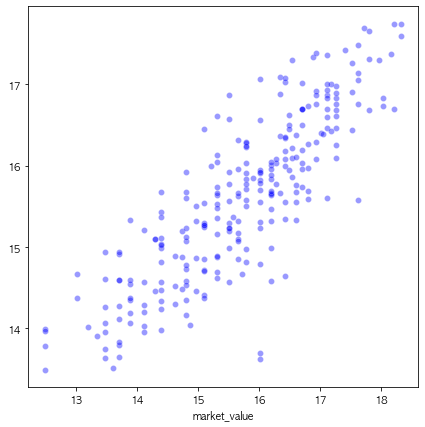

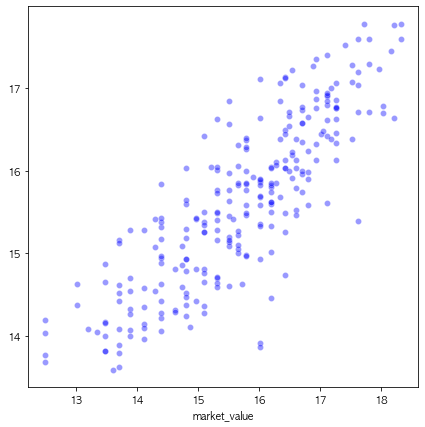

In [101]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

randomfr_model = RandomForestRegressor()
randomfr_model.fit(X_train, y_train)

randomfr_pred = randomfr_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(randomfr_pred, y_test))
print('평균제곱근오차', rmse)
plt.figure(figsize=(7,7))
sns.scatterplot(y_test, randomfr_pred, alpha=0.4,color='blue');


tuned_hyper_randomfr_model= RandomForestRegressor(bootstrap= True,
 max_depth= 9,
 max_features= 'auto',
 min_samples_leaf= 2,
 min_samples_split= 2,
 n_estimators= 800)

tuned_hyper_randomfr_model.fit(X_train,y_train)

tuned_hyper_randomfr_pred = tuned_hyper_randomfr_model.predict(X_test)
tuned_hyper_randomfr_rmse = np.sqrt(mean_squared_error(tuned_hyper_randomfr_pred, y_test))
print('평균제곱근오차', tuned_hyper_randomfr_rmse)
print('r2_score: {}'.format(r2_score(y_test, tuned_hyper_randomfr_pred)))
plt.figure(figsize=(7,7))
sns.scatterplot(y_test, tuned_hyper_randomfr_pred, alpha=0.4,color='blue');

### 최종 OLS 모델에 대한 독립변수들의 가중치 시각화

In [231]:
param_df = model_8.params.reset_index(name='weight')
param_df = param_df.iloc[1:]
param_df.rename(columns={'index': 'var'}, inplace=True)
param_df.head()

,var,weight
1,C(label)[T.1],0.792850
2,scale(app),0.318659
3,scale(conceded_goals),-0.078917
4,scale(clean_sheets),0.065314
5,scale(yellow_card),-0.049831


In [227]:
non_var = ["scale(Tackles)", "scale(Fouls)", "scale(Offsides)", "scale(Drbed)", "scale(Blocks)", "scale(OwnG)", "scale(Crosses)",
           "scale(LongB)", "scale(ThrB)", "scale(UnsTch)", "scale(AerialsWon)", "scale(MotM)"]

data = [float(param_df[param_df["var"] == var]['weight'].values) if var in non_var else 0
    for var in param_df['var'].values.tolist()]

datas = param_df.copy()
datas['weight'] = data

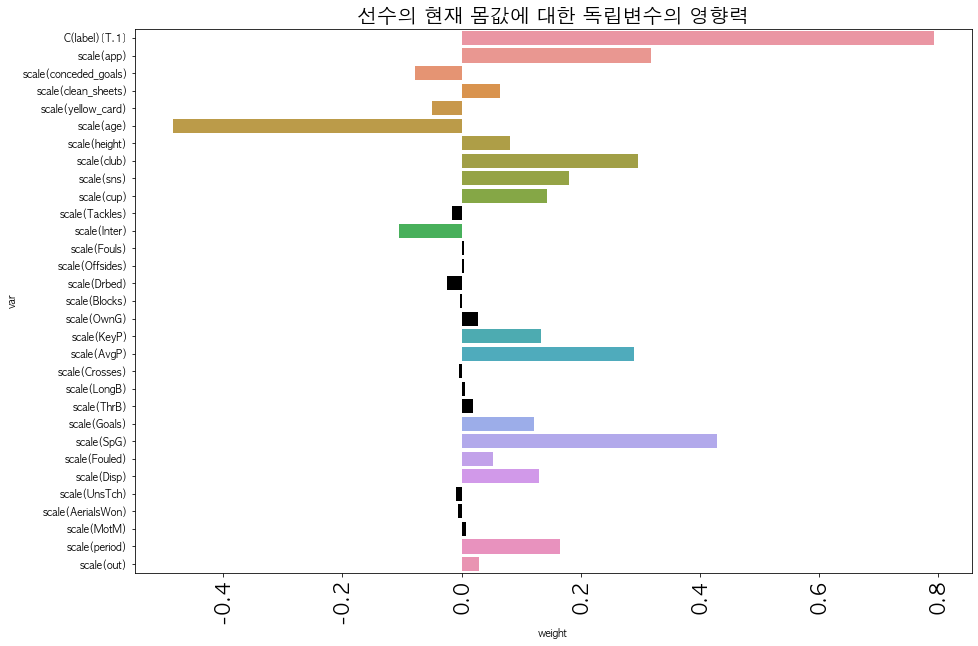

In [239]:
plt.figure(figsize=(15, 10))

sns.barplot(data=param_df, x='weight', y='var', orient='h')
sns.barplot(data=datas, x='weight', y='var', color='black')
plt.xticks(rotation=90, fontsize=20)
plt.title("선수의 현재 몸값에 대한 독립변수의 영향력", fontsize=20)

plt.show()

# 결론

- 모든 수치형 변수와 범주형 변수의 class들을 모두 살려서 모델링을 했을 때의 r2-score가 0.7195로 가장 높았지만 각 변수에 대한 설명력이 떨어졌음

- 반복된 데이터 전처리와 모델링을 통해 r2-score : 0.7425, mse : 0.4196, rmse : 0.6477 까지 성능을 끌여올렸고 각 변수에 대한 설명력도 좋아짐
    - second_yell과 red_card 컬럼의 결합
    - outfitter 컬럼 제거
    - club을 챔스, 유로파, 일반, 강등으로 나눠 score를 부여함으로써 수치형 변수로 변환 > out
    - VIF를 통해 다중공선성이 있고, p-value가 높은 독립변수들을 추출해 KMeans를 통한 파생변수 생성 > label
    - 모든 수치형 변수 scaling
    - 종속변수 log scaling

- 두 가지 방법을 통한 아웃라이어 제거를 진행하였는데 제거하지 않은 모델의 성능이 더 좋았음 > 아웃라이어 제거X